# Supplemental Figures

## Setup

### imports

In [64]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from tqdm import tqdm

from dms_3d_features.plotting import *
from tabulate import tabulate
import re
import os


from rna_motif_library.dataframe_tools import (  # pyright: ignore[reportMissingImports]
    add_motif_indentifier_columns,
)

## load data

In [65]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [ ]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df = df1.query("r_type != 'Flank-WC'").copy()
df_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
# generate natural log of DMS
with np.errstate(divide="ignore"):
    df1["ln_r_data"] = np.log(df1["r_data"])
df1["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
df = df.query("r_data_outlier == False").copy()

df_bp_details = pd.read_csv(f"{DATA_PATH}/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df_bp_details["r_data"])
df_bp_details["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df_pdb = df_pdb.query("r_data_outlier == False").copy()
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

# merge and remove extra pdb res
df_sasa_merge = pd.merge(
    df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"]
)
df_sasa_merge = df_sasa_merge.query("not ln_r_data.isnull()")

df_dist = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)

df_wc = df1.query("r_type == 'Flank-WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)



/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
# Filter rows where pdb_path is an empty list
df_no_pdb = df1.query("has_pdbs == False").copy()

# Remove rows where m_token contains 'HELIX'
df_no_pdb = df_no_pdb[~df_no_pdb["m_token"].str.contains("HELIX", na=False)]

# Get unique values of m_sequence
unique_m_sequences = df_no_pdb["m_sequence"].unique()
print("Number of unique m_sequences (after removing HELIX):", len(unique_m_sequences))

# Get unique values of m_token
unique_m_tokens = df_no_pdb["m_token"].unique()
print("Unique m_tokens (after removing HELIX):", unique_m_tokens)

Number of unique m_sequences (after removing HELIX): 536
Unique m_tokens (after removing HELIX): ['1x1' '2x2']


## Extra functions

In [69]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [70]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [72]:
def calculate_sasa_percentages(df_non_wc_pair, sasa_thresholds=[2]):
    results = []
    for threshold in sasa_thresholds:
        below_threshold = (
            df_non_wc_pair[df_non_wc_pair["sasa_0_5"] < threshold].groupby("cat").size()
        )
        total = df_non_wc_pair.groupby("cat").size()
        percentage = (below_threshold / total * 100).round(2)

        results.append(percentage.rename(f"Percent_below_{threshold}"))

    result_df = pd.concat(results, axis=1).fillna(0)
    result_df["Count"] = df_non_wc_pair.groupby("cat").size()

    headers = ["Category"] + list(result_df.columns)
    table_data = [[index] + row.tolist() for index, row in result_df.iterrows()]

    return tabulate(table_data, headers=headers, tablefmt="pipe", floatfmt=".2f")

# Plotting

## Supplemental Figure S8 – Median CV ratio (WC/Non-WC) for different data groupings

In [90]:
# Group the data and calculate statistics
df_fig_1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_second_stack = (
    df_fig_1.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

In [91]:
df_sub = pd.read_csv(f"{REVISION_PATH}/cv_csvs/randomized_cvs.csv")

In [92]:
df_cv = (
    df_fig_1.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "None"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_sub["data_type"] = "Random"
df_all = pd.concat([df_second_stack_cv, df_cv, df_sub]).reset_index(drop=True)

In [93]:
# Create median dataframe
median_df = (
    df_all.groupby(["r_type", "data_type"])["cv_r_data"]
    .median()
    .reset_index()
    .rename(columns={"cv_r_data": "median_cv"})
)
print(median_df)

     r_type     data_type  median_cv
0  Flank-WC          None   0.470574
1  Flank-WC        Random   0.360719
2  Flank-WC  Second Stack   0.342823
3    NON-WC          None   0.293180
4    NON-WC        Random   0.252336
5    NON-WC  Second Stack   0.211946
6        WC          None   0.506690
7        WC  Second Stack   0.433683


In [94]:
# Calculate WC / NON-WC median CV ratios for each data_type
ratios = (
    median_df.pivot(index="data_type", columns="r_type", values="median_cv")
    .reset_index()
    .assign(median_ratio_WC_vs_NON_WC=lambda d: d["Flank-WC"] / d["NON-WC"])
)
print("Median CV ratios (WC / NON-WC):")
print(ratios[["data_type", "median_ratio_WC_vs_NON_WC"]])

Median CV ratios (WC / NON-WC):
r_type     data_type  median_ratio_WC_vs_NON_WC
0               None                   1.605066
1             Random                   1.429521
2       Second Stack                   1.617500


In [95]:
def bootstrap_ratio(df, group_name, n_boot=5000):
    wc = df.query("r_type == 'Flank-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values
    non_wc = df.query("r_type == 'NON-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values

    ratios = []
    for _ in tqdm(range(n_boot)):
        wc_sample = np.random.choice(wc, size=len(wc), replace=True)
        non_wc_sample = np.random.choice(non_wc, size=len(non_wc), replace=True)
        ratio = np.median(wc_sample) / np.median(non_wc_sample)
        ratios.append(ratio)

    return np.array(ratios)


# Bootstrap for Random and Second Stack
ratios_random = bootstrap_ratio(df_all, "Random")
ratios_stack = bootstrap_ratio(df_all, "Second Stack")

# Compare to the baseline value from "None"
baseline_ratio = 1.464442

# 95% confidence intervals
ci_random = np.percentile(ratios_random, [0.5, 99.5])
ci_stack = np.percentile(ratios_stack, [0.5, 99.5])

print(
    f"Random 99% CI: {ci_random}, contains baseline? {ci_random[0] <= baseline_ratio <= ci_random[1]}"
)
print(
    f"Second Stack 99% CI: {ci_stack}, contains baseline? {ci_stack[0] <= baseline_ratio <= ci_stack[1]}"
)

100%|██████████| 5000/5000 [00:02<00:00, 1718.76it/s]

Random 99% CI: [1.40874913 1.45259198], contains baseline? False
Second Stack 99% CI: [1.58934864 1.64569475], contains baseline? False


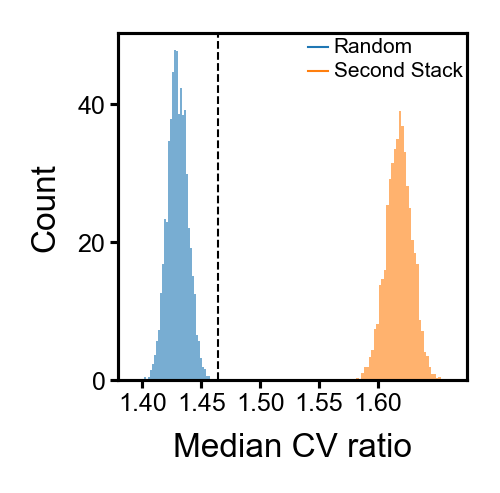

In [96]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
import matplotlib.lines as mlines

wc_patch = mlines.Line2D([], [], color="#1f77b4", lw=0.5, label="Random")
nonwc_patch = mlines.Line2D([], [], color="#ff7f0e", lw=0.5, label="Second Stack")

ax.hist(
    ratios_random, bins=40, alpha=0.6, label="Random", density=True, color="#1f77b4"
)
ax.hist(
    ratios_stack,
    bins=40,
    alpha=0.6,
    label="Second Stack",
    density=True,
    color="#ff7f0e",
)

ax.axvline(
    baseline_ratio,
    color="black",
    linestyle="--",
    linewidth=0.5,
)

ax.set_xlabel("Median CV ratio")
ax.set_ylabel("Count")
ax.set_xticks([1.40, 1.45, 1.50, 1.55, 1.60])

# Make legend with Arial font and right up against the axes, and reduce vertical spacing
arial_font = {"family": "Arial", "size": 5}

legend = ax.legend(
    handles=[wc_patch, nonwc_patch],
    frameon=False,
    loc="upper right",
    handlelength=1.0,
    handleheight=0.01,
    handletextpad=0.25,
    borderaxespad=-0.2,  # as close as possible to axes
    prop=arial_font,
    labelspacing=0.2,  # reduce space between lines in legend
)

publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

## Supplemental Figure S9: Quantitative analysis of DMS reactivity in WC and non-WC nucleotides  

In [97]:
df1["r_type_simple"] = df1["r_type"].replace("Flank-WC", "WC")

<Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Type'>

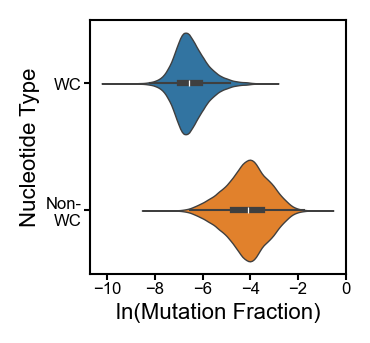

In [98]:
def plot_figure_s8a(df, ax):
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type_simple",
        data=df,
        hue="r_type_simple",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-\nWC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8a(df1, ax)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Cumulative Dist. (%)'>

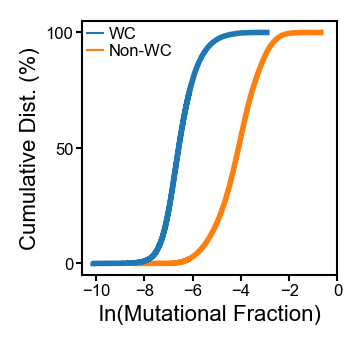

In [99]:
def plot_figure_s8b(df, ax):
    df.sort_values("r_type", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type_simple"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Dist. (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    add_legend(ax, ["WC", "Non-WC"], loc="upper left")
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8b(df1, ax)

In [100]:
df1["ln_r_data"].replace(-np.inf, -10, inplace=True)
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df1["r_type_binary"] = df1["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df1[["ln_r_data"]], df1["r_type_binary"])
# Compute probabilities for the original data
df1["prob_WC"] = model.predict_proba(df1[["ln_r_data"]])[:, 1]
# Display the probabilities
df1.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type_simple", "prob_WC"]]

,ln_r_data,r_type_simple,prob_WC
159066,-10.126631,WC,1.000000
158030,-10.126631,WC,1.000000
330548,-9.903488,WC,0.999999
159518,-9.903488,WC,0.999999
159689,-9.903488,WC,0.999999
...,...,...,...
463233,-1.013022,NON-WC,0.000006
463209,-0.994414,NON-WC,0.000005
105290,-0.972755,NON-WC,0.000005
105296,-0.853363,NON-WC,0.000004


In [101]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df1["abs_diff"] = (df1["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df1["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df1.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.137900645142132


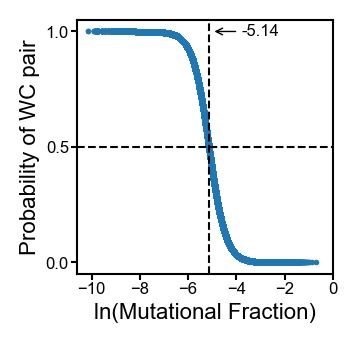

In [102]:
def plot_figure_s8c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])

    # reference lines
    ax.axhline(y=0.5, color="black", linestyle="--", lw=0.75)
    ax.axvline(x=-5.14, color="black", linestyle="--", lw=0.75)

    # Move text and arrow up further, make arrow longer, move text back
    text_y = 1.0
    arrow_y = 1.0
    arrow_tip_x = -5.14
    arrow_start_x = -3.8  # make arrow longer
    text_x = -3.8  # move text back

    # text label (no arrow)
    ax.text(
        text_x, text_y, "-5.14", fontsize=6, fontname="Arial", ha="left", va="center"
    )
    # separate arrow, perfectly horizontal, longer and higher
    ax.annotate(
        "",
        xy=(arrow_tip_x, arrow_y),  # arrow tip on the line
        xytext=(arrow_start_x, arrow_y),  # start point of arrow (same y, further x)
        arrowprops=dict(arrowstyle="->", lw=0.5, color="black", mutation_scale=6),
    )
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8c(df1, ax)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Count (×10³)'>

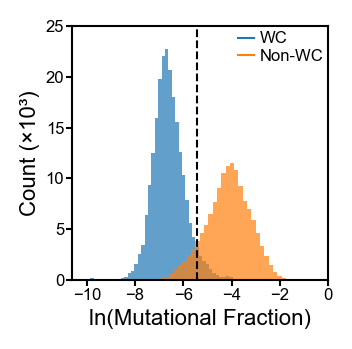

In [103]:
def plot_figure_s8d(df, ax, threshold=-5.45):
    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )
    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)

    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.set_yticks(
        [0, 5000, 10000, 15000, 20000, 25000], labels=["0", "5", "10", "15", "20", "25"]
    )
    add_legend(ax, ["WC", "Non-WC"], loc="upper right")
    publication_style_ax(ax)
    return ax


# Create and save plot
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8d(df, ax)

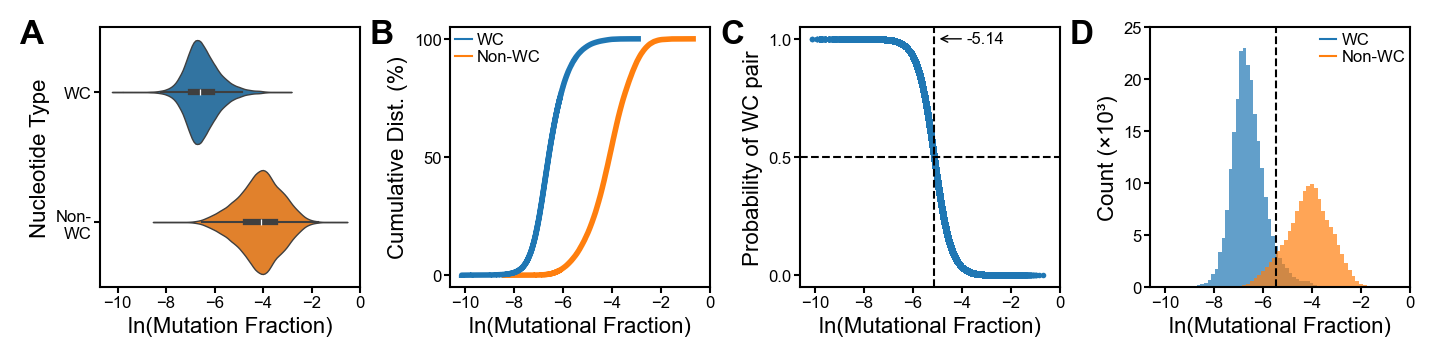

In [104]:
fig_size = (7, 2)
layout = (1, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)

ax1 = fig.add_axes(coords_list[0])
plot_figure_s8a(df1, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_figure_s8b(df1, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_figure_s8c(df1, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_figure_s8d(df1, ax4)
add_subplot_labels(fig, coords_list)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_8.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S10 – The reactivity distribution for Flank-WC pairs and non-WC under denaturing conditions

In [105]:
df_denature_res = pd.read_json(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_denature_residues_2000.json"
)
df_denature_res["ln_r_data"] = df_denature_res["ln_r_data"].replace(-np.inf, -9.8)

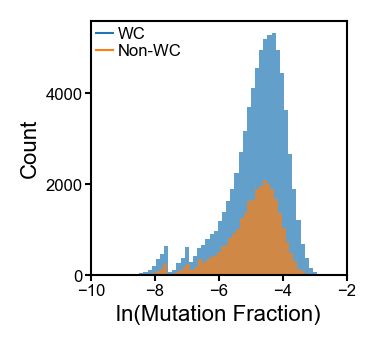

In [106]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)

ax.hist(
    df_denature_res.query(
        "(r_type == 'WC' or r_type == 'Flank-WC') and ln_r_data > -9"
    )["ln_r_data"],
    bins=50,
    alpha=0.7,
    label="Flank-WC",
)
ax.hist(
    df_denature_res.query("r_type == 'NON-WC' and ln_r_data != -9.8")["ln_r_data"],
    bins=50,
    alpha=0.7,
    label="NON-WC",
)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim(-10, -2)
ax.set_xticks([-10, -8, -6, -4, -2])
add_legend(ax, ["WC", "Non-WC"], loc="upper left")
publication_style_ax(ax)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s10.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S11: Non-WC and WC overlaps with different normalization methods

### Extra functions

In [107]:
def fit_logistic_regression(df):
    df = df.copy()
    df = df.query("r_type == 'Flank-WC' or r_type == 'NON-WC'").copy()
    df["r_type_simple"] = df["r_type"].replace("Flank-WC", "WC")
    df["r_type_binary"] = df["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
    model = LogisticRegression()
    model.fit(df[["ln_r_data"]], df["r_type_binary"])
    # Compute probabilities for the original data
    df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
    # Display the probabilities
    df.sort_values("prob_WC", ascending=False)[
        ["ln_r_data", "r_type_simple", "prob_WC"]
    ]
    # Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
    df["abs_diff"] = (df["prob_WC"] - 0.50).abs()
    # Find the index of the minimum difference
    min_index = df["abs_diff"].idxmin()
    # Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
    closest_row = df.loc[min_index]
    return closest_row["ln_r_data"]


def plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold=-5.45):
    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'Flank-WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )

    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    return ax


def get_avg_reference_hairpin_reactivity_from_row(row):
    # Create an object from sequence and structure
    struct = SecStruct(row["sequence"], row["structure"])

    # Extract hairpin motifs from the object
    hairpins = struct.get_hairpins()
    if len(hairpins) == 0:
        print(f"Warning: No hairpins found for {row['name']}")
        return None

    hairpin = hairpins[0]
    pos1 = hairpins[0].positions[2]
    pos2 = hairpins[0].positions[5]
    return (row["data"][pos1] + row["data"][pos2]) / 2


def compute_distribution_splits(df, threshold, column="reac_ratio"):
    # Extract data
    blue = df.query("r_type == 'Flank-WC'")[column].dropna()
    orange = df.query("r_type == 'NON-WC'")[column].dropna()

    # Percentage of orange (NON-WC) to the left of threshold
    orange_left_pct = np.mean(orange < threshold) * 100

    # Percentage of blue (Flank-WC) to the right of threshold
    blue_right_pct = np.mean(blue > threshold) * 100

    return orange_left_pct, blue_right_pct


def plot_flank_wc_nonwc_overlap_with_percentages(df, ax):
    """
    Plots the overlap of Flank-WC and Non-WC distributions with threshold and annotates percentages.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data to plot.
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    """
    threshold = fit_logistic_regression(df)
    plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold)
    ax.set_yticks([0, 5000, 10000], labels=["0", "5", "10"])
    # add_legend(ax, ["Flank-WC", "Non-WC"])
    orange_left, blue_right = compute_distribution_splits(
        df, threshold, column="ln_r_data"
    )
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    # Add orange_left in top left, blue_right in top right, both bold Arial and colored
    ax.text(
        0.01,
        0.98,
        f"{orange_left:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:orange",
        va="top",
        ha="left",
    )
    ax.text(
        0.99,
        0.98,
        f"{blue_right:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:blue",
        va="top",
        ha="right",
    )

### load data

In [108]:
df_nomod_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_nomod_normalized_residues.json"
)
df_nomod_norm_res = df_nomod_norm_res.query("ln_r_data > -9")

df_denature_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_denature_normalized_residues.json"
)
df_denature_norm_res = df_denature_norm_res.query("ln_r_data > -9")

df_res = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_res["ln_r_data"] = np.log(df_res["r_data"])
df_res["ln_r_data"] = df_res["ln_r_data"].replace(-np.inf, -9.8)
df_res = df_res.query("ln_r_data > -9")

df_denature_res = pd.read_json(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_denature_residues_2000.json"
)
df_denature_res["ln_r_data"] = df_denature_res["ln_r_data"].replace(-np.inf, -9.8)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### subplots

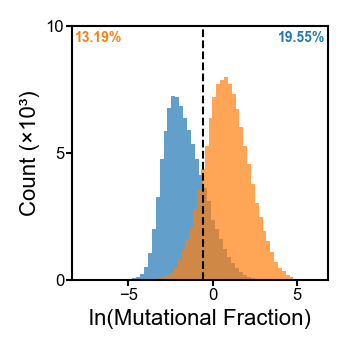

In [109]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax)

In [110]:
df_res_norm_by_avg = df_res.copy()
df_res_norm_by_avg["norm_r_data"] = df_res_norm_by_avg["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    avg = np.mean(row["data"])
    df_res_norm_by_avg.loc[g.index, "norm_r_data"] = g["r_data"] / avg

df_res_norm_by_avg["ln_norm_r_data"] = np.log(df_res_norm_by_avg["norm_r_data"])
df_res_norm_by_avg.loc[
    np.isinf(df_res_norm_by_avg["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_avg = df_res_norm_by_avg.query("ln_norm_r_data > -9")
df_res_norm_by_avg["ln_r_data"] = df_res_norm_by_avg["ln_norm_r_data"]

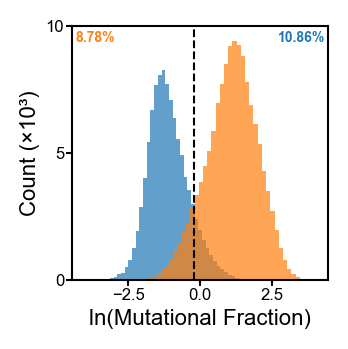

In [111]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax)

In [112]:
df_res_norm_by_ref_hp = df_res.copy()
df_res_norm_by_ref_hp["norm_r_data"] = df_res_norm_by_ref_hp["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    ref_a_avg = get_avg_reference_hairpin_reactivity_from_row(row)
    df_res_norm_by_ref_hp.loc[g.index, "norm_r_data"] = g["r_data"] / ref_a_avg

df_res_norm_by_ref_hp["ln_norm_r_data"] = np.log(df_res_norm_by_ref_hp["norm_r_data"])
df_res_norm_by_ref_hp.loc[
    np.isinf(df_res_norm_by_ref_hp["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_ref_hp = df_res_norm_by_ref_hp.query("ln_norm_r_data > -9")
df_res_norm_by_ref_hp["ln_r_data"] = df_res_norm_by_ref_hp["ln_norm_r_data"]

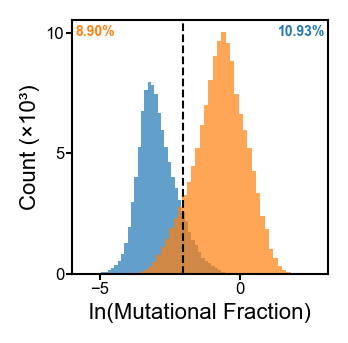

In [113]:
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax)

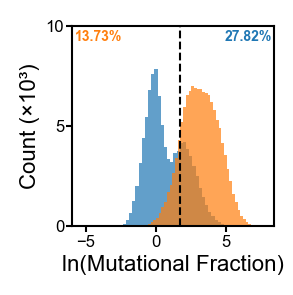

In [114]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax)

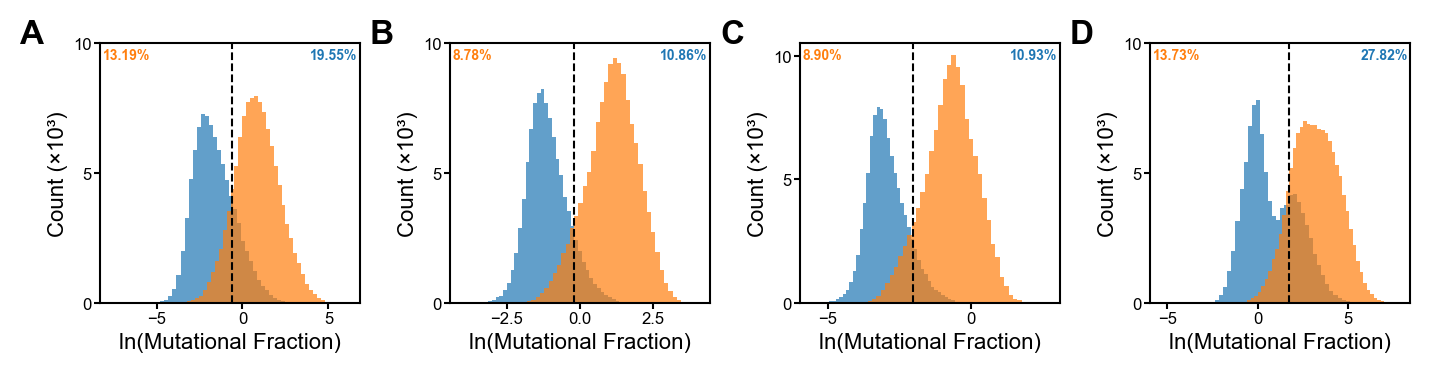

In [115]:
fig_size = (7, 6)
layout = (1, 4)
subplot_size = (1.3, 1.3)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
ax1 = fig.add_axes(coords_list[0])
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax4)
add_subplot_labels(fig, coords_list)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s11.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S12: Quantitative analysis of reactivity of flanking WC pairs to base pair parameters

/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:787: UserWarning: Subplots won't fit vertically! Required height: 3.60", Figure height: 2.00". Consider increasing figure height or reducing subplot height/spacing.
  warnings.warn(


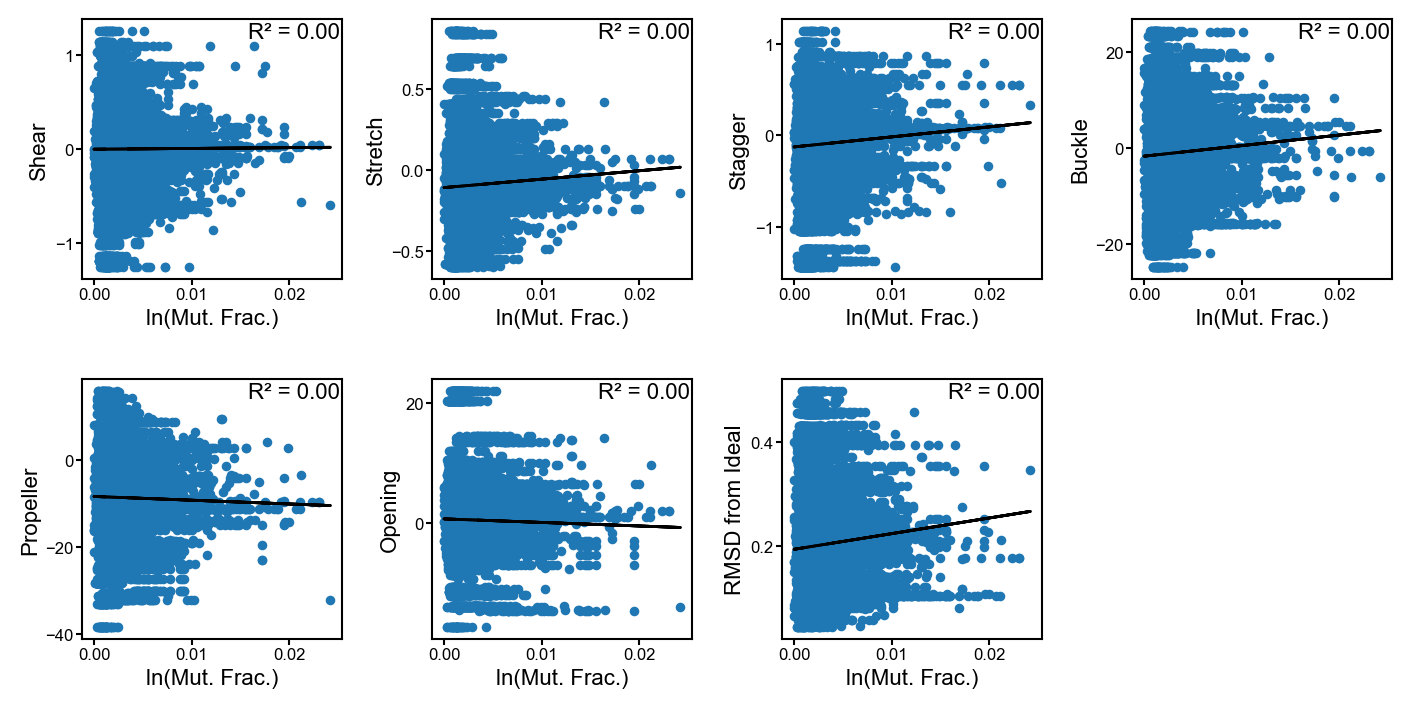

In [116]:
fig_size = (7, 2)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)

feature_columns = [
    "shear",
    "stretch",
    "stagger",
    "buckle",
    "propeller",
    "opening",
    "rmsd_from_ideal",
]

for i, feature in enumerate(feature_columns):
    ax = fig.add_axes(coords_list[i])
    scatter_plot_w_regression(df_bp_details, ax, "r_data", feature)
    ax.set_xlabel("ln(Mut. Frac.)", labelpad=2)
    if i == len(feature_columns) - 1:
        ax.set_ylabel("RMSD from Ideal", labelpad=2)
    else:
        ax.set_ylabel(feature.capitalize(), labelpad=2)
    publication_style_ax(ax)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s12.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S14: Correlation between SASA 0.5 with ln DMS

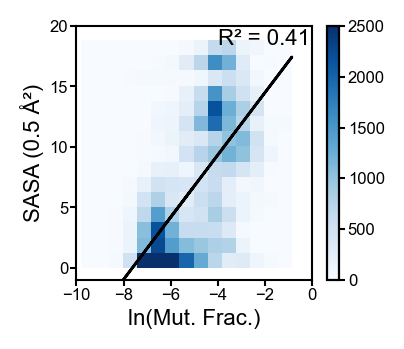

In [117]:
fig, ax = plt.subplots(figsize=(1.90, 1.65), dpi=200)
# scatter_plot_w_regression(df_sasa_merge, ax, "ln_r_data", "sasa_0_5", r2_position=(0.05, 0.95))
heatmap_scatter_plot_w_regression(
    df_sasa_merge, ax, "ln_r_data", "sasa_0_5", bins=15, max_value=2500
)
ax.set_xlabel("ln(Mut. Frac.)", labelpad=2)
ax.set_ylabel(f"SASA (0.5 Å\u00b2)", labelpad=2)
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_xticks([-10, -8, -6, -4, -2, 0])
ax.set_ylim([-1, 20])
publication_style_ax(ax)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s14.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S15: Impact of neighboring sequences on mismatches

In [118]:
def plot_stack_type(df, pair, ax):
    df_pair = df.query(
        f"r_nuc == '{pair[0]}' and r_type == 'NON-WC' and likely_pair == '{pair}'"
    ).copy()
    df_pair["stack_type"] = df_pair.apply(assign_stack_type, axis=1)
    ax = plot_violins_w_percent(
        df_pair,
        "ln_r_data",
        "stack_type",
        cutoff=-5.45,
        color=None,
        gt_lt="less",
        xlim=(-10, -1),
        sorted_by_mean=True,
        ax=ax,
    )
    color_map = {
        "both_purine": "tab:blue",
        "mixed": "tab:orange",
        "both_pyrimidine": "tab:green",
    }

    # Update the colors based on the x-tick labels
    for violin, label in zip(ax.collections, ax.get_yticklabels()):
        stack_type = label.get_text()
        if stack_type in color_map:
            violin.set_facecolor(color_map[stack_type])

    ax.set_ylabel("Stack type", labelpad=2)
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_yticklabels(["purine", "mixed", "pyrim."])
    ax.set_xticks([-10, -8, -6, -4, -2])
    publication_style_ax(ax)
    return ax

In [119]:
df1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:444: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(
/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_15767/1275614268.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["purine", "mixed", "pyrim."])
/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:444: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(
/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_15767/1275614268.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["purine", "mixed", "pyrim."])
/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:444: UserWarning: The palette list has more values (10) than needed (3), whic

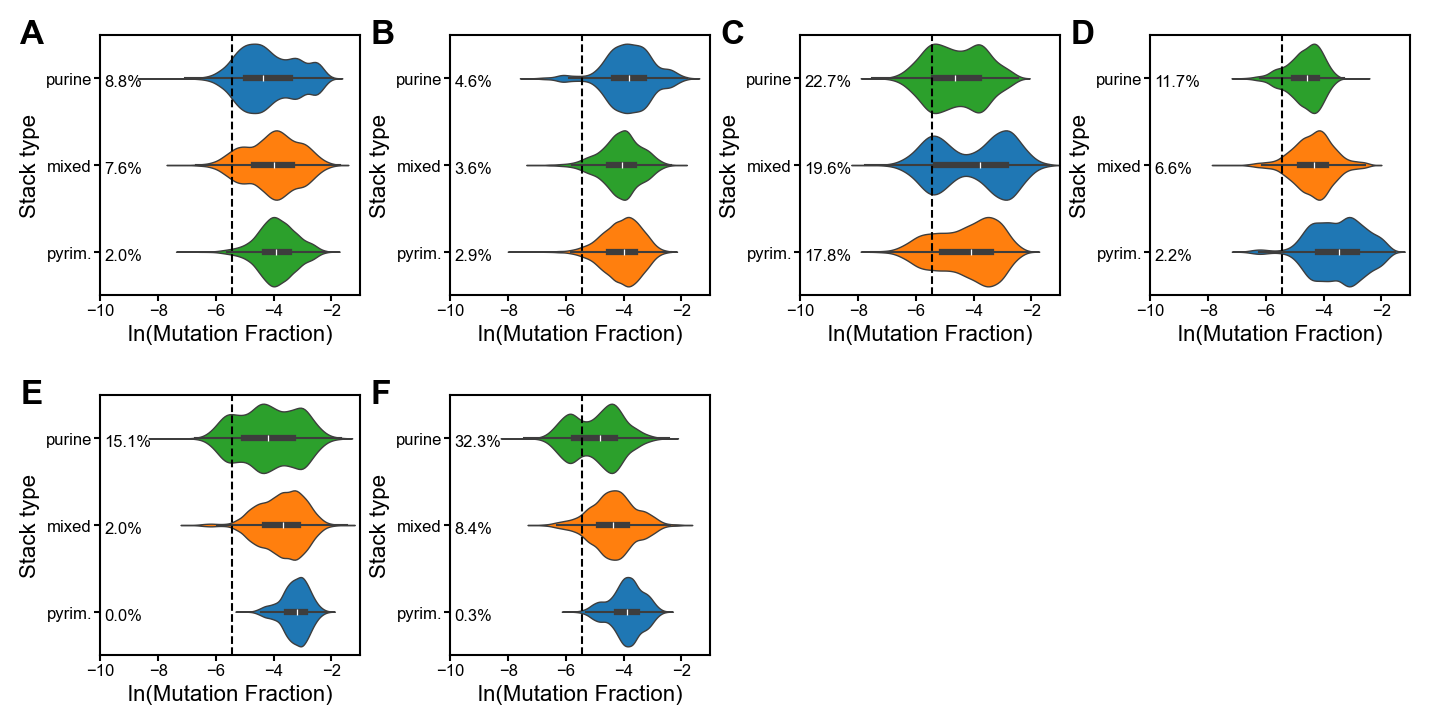

In [120]:
fig_size = (7, 4)
layout = (2, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
pairs = ["AA", "AC", "AG", "CA", "CC", "CU"]
for i, pair in enumerate(pairs):
    ax = fig.add_axes(coords_list[i])
    plot_stack_type(df1, pair, ax)
add_subplot_labels(fig, coords_list[0:6])
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s15.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S16: Weaker correlations between mismatched pairs and DMS reactivity

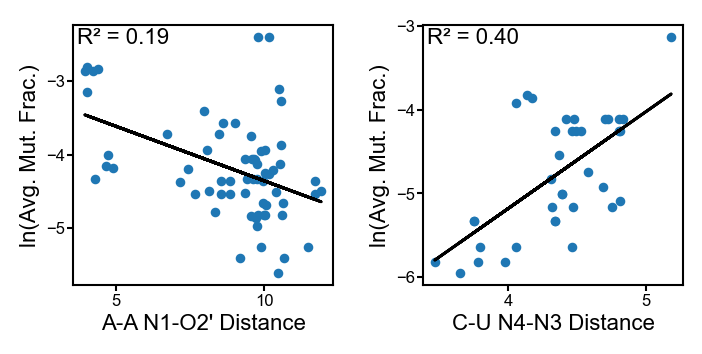

In [121]:
fig_size = (7, 2)
layout = (1, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
dfs = [
    df_dist.query('pair == "A-A" and atom1 == "N1" and atom2 == "O2\'"'),
    df_dist.query('pair == "C-U" and atom1 == "N4" and atom2 == "N3"'),
]
labels = ["A-A N1-O2'", "C-U N4-N3"]
for i, df in enumerate(dfs):
    ax = fig.add_axes(coords_list[i])
    scatter_plot_w_regression(
        df, ax, "distance", "ln_r_data_mean", r2_position=(0.37, 0.99)
    )
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xlabel(labels[i] + " Distance", labelpad=2)
    publication_style_ax(ax)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s16.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S17: Correlation plots of the top 10 atomic pair correlations for A-G pairs

/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:787: UserWarning: Subplots won't fit vertically! Required height: 5.40", Figure height: 4.00". Consider increasing figure height or reducing subplot height/spacing.
  warnings.warn(


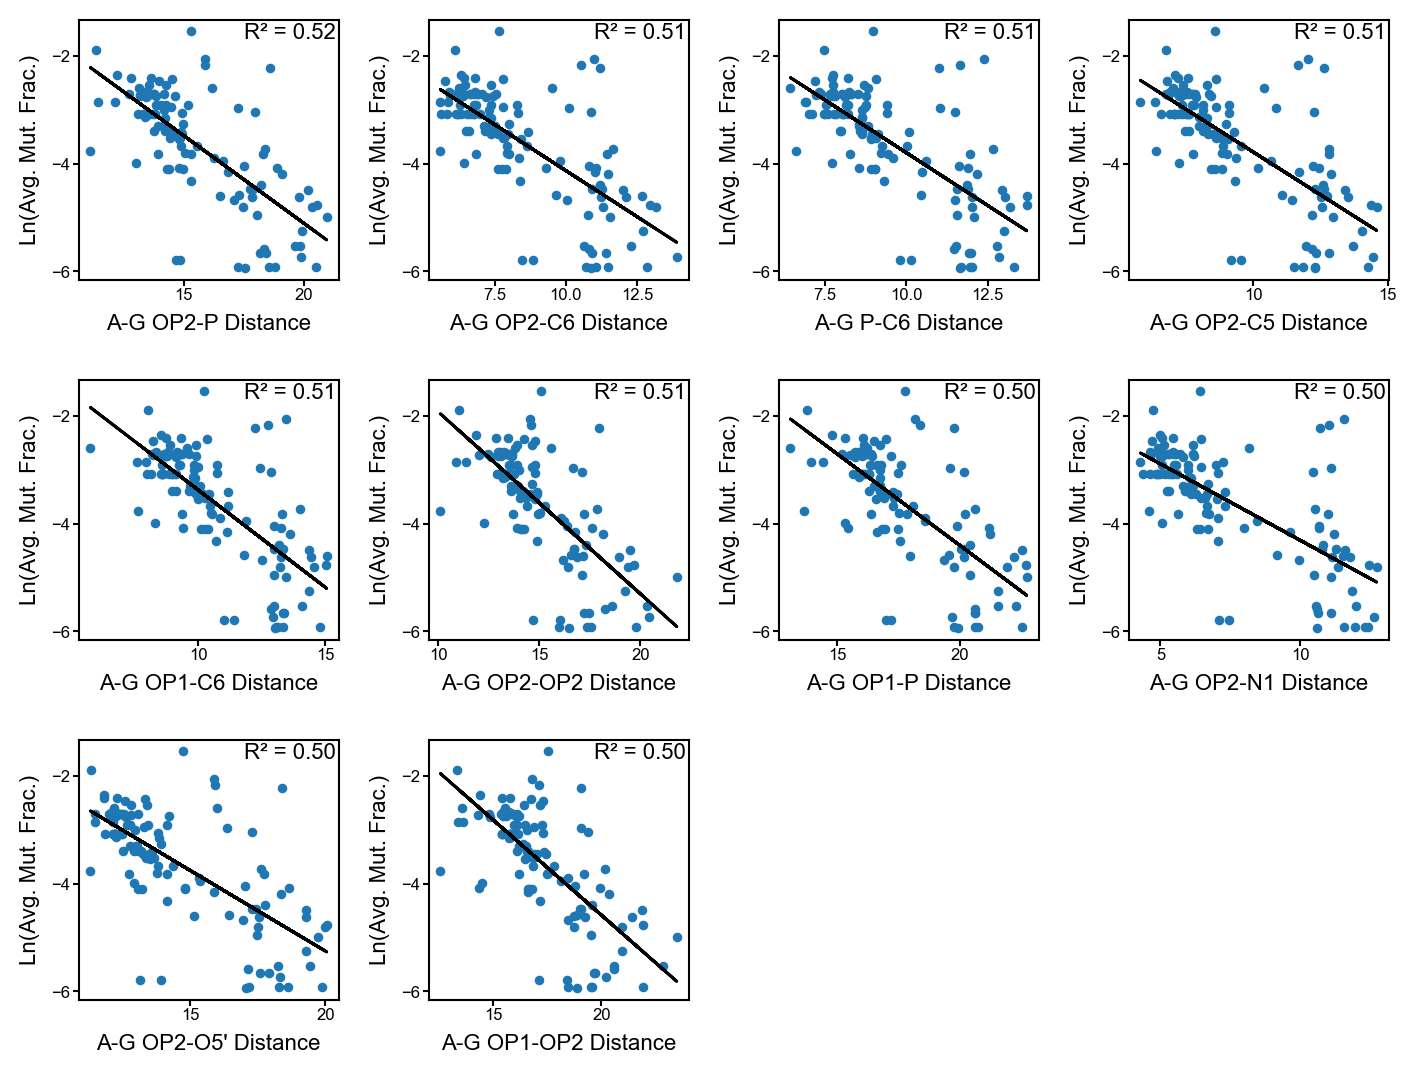

In [122]:
df_dist_ag = df_dist.query('pair == "A-G" and ln_r_data_mean != ""').copy()
df_unique = df_dist_ag.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"]).copy()
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(3)

fig_size = (7, 4)
layout = (3, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
pos = 0
for i, row in df_top_10.iterrows():
    df_plot = df_dist.query(
        f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"'
    ).copy()
    ax = fig.add_axes(coords_list[pos])
    scatter_plot_w_regression(
        df_plot,
        ax,
        "distance",
        "ln_r_data_mean",
    )
    ax.set_xlabel(f'A-G {row["atom1"]}-{row["atom2"]} Distance')
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
    publication_style_ax(ax)
    pos += 1

fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s17.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S18: Correlation plots of the top 10 atomic pair correlations for C-A pairs

/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:787: UserWarning: Subplots won't fit vertically! Required height: 5.40", Figure height: 4.00". Consider increasing figure height or reducing subplot height/spacing.
  warnings.warn(


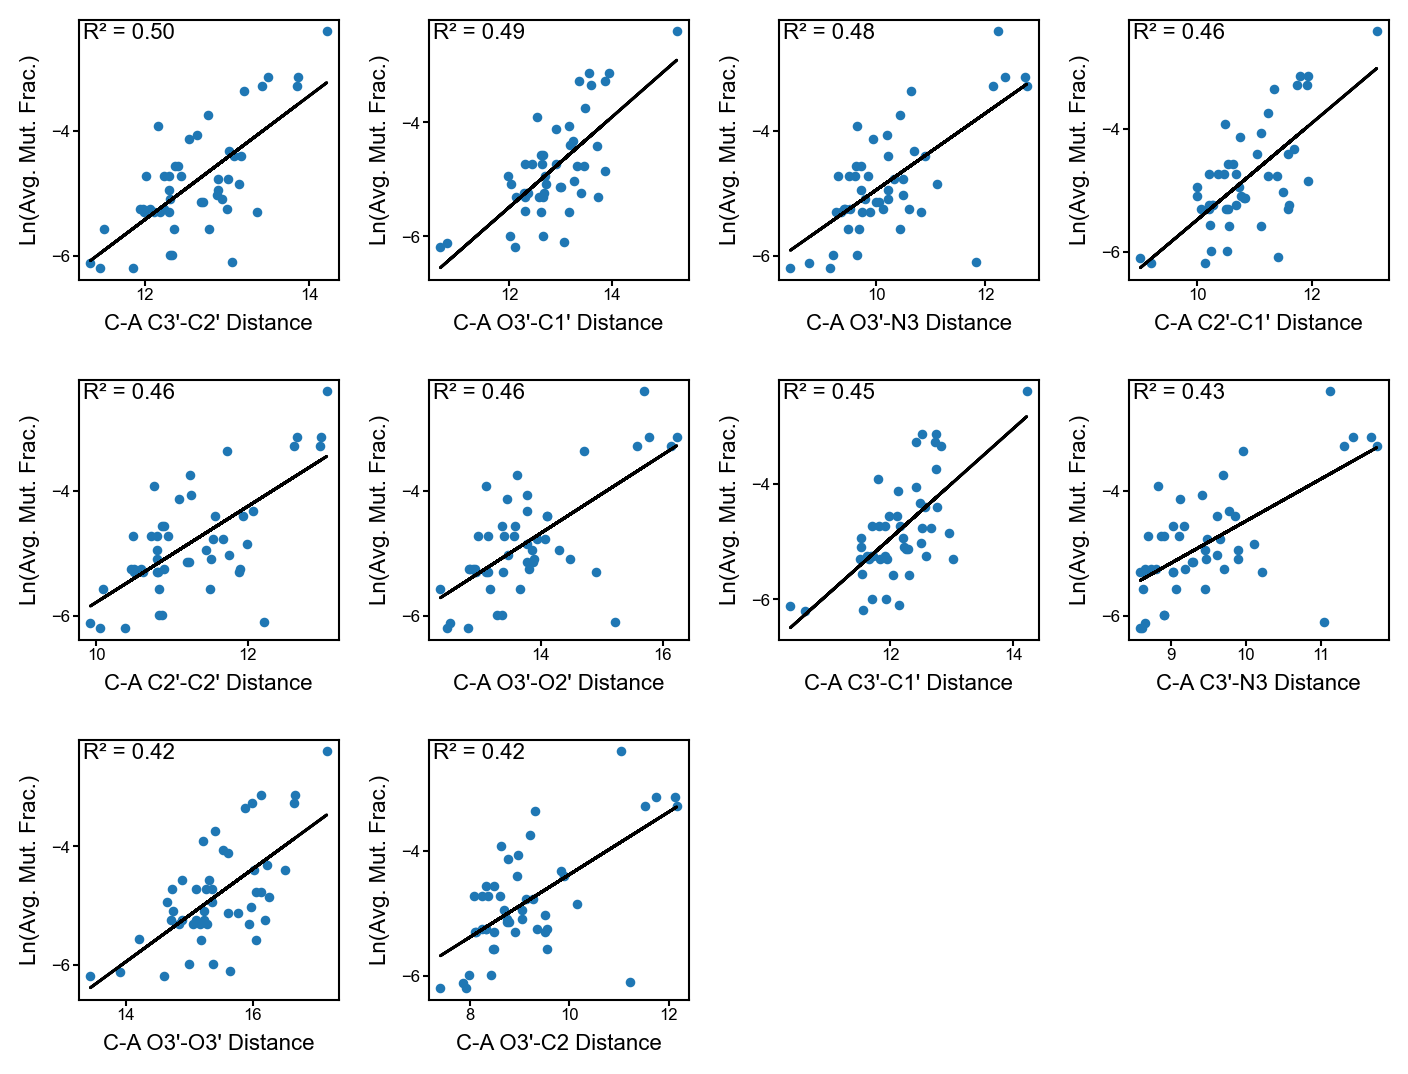

In [123]:
df_dist_ca = df_dist.query('pair == "C-A" and ln_r_data_mean != ""').copy()
df_unique = df_dist_ca.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"]).copy()
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

fig_size = (7, 4)
layout = (3, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
pos = 0
for i, row in df_top_10.iterrows():
    df_plot = df_dist.query(
        f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"'
    ).copy()
    ax = fig.add_axes(coords_list[pos])
    scatter_plot_w_regression(
        df_plot, ax, "distance", "ln_r_data_mean", r2_position=(0.37, 0.99)
    )
    ax.set_xlabel(f'C-A {row["atom1"]}-{row["atom2"]} Distance')
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
    publication_style_ax(ax)
    pos += 1
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s18.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S20: Correlation plots of the top 10 atomic pair correlations for C-C pairs

/Users/jyesselman2/Dropbox/4_papers/2024_dms_quant_framework/dms_3d_features/plotting.py:787: UserWarning: Subplots won't fit vertically! Required height: 5.40", Figure height: 4.00". Consider increasing figure height or reducing subplot height/spacing.
  warnings.warn(


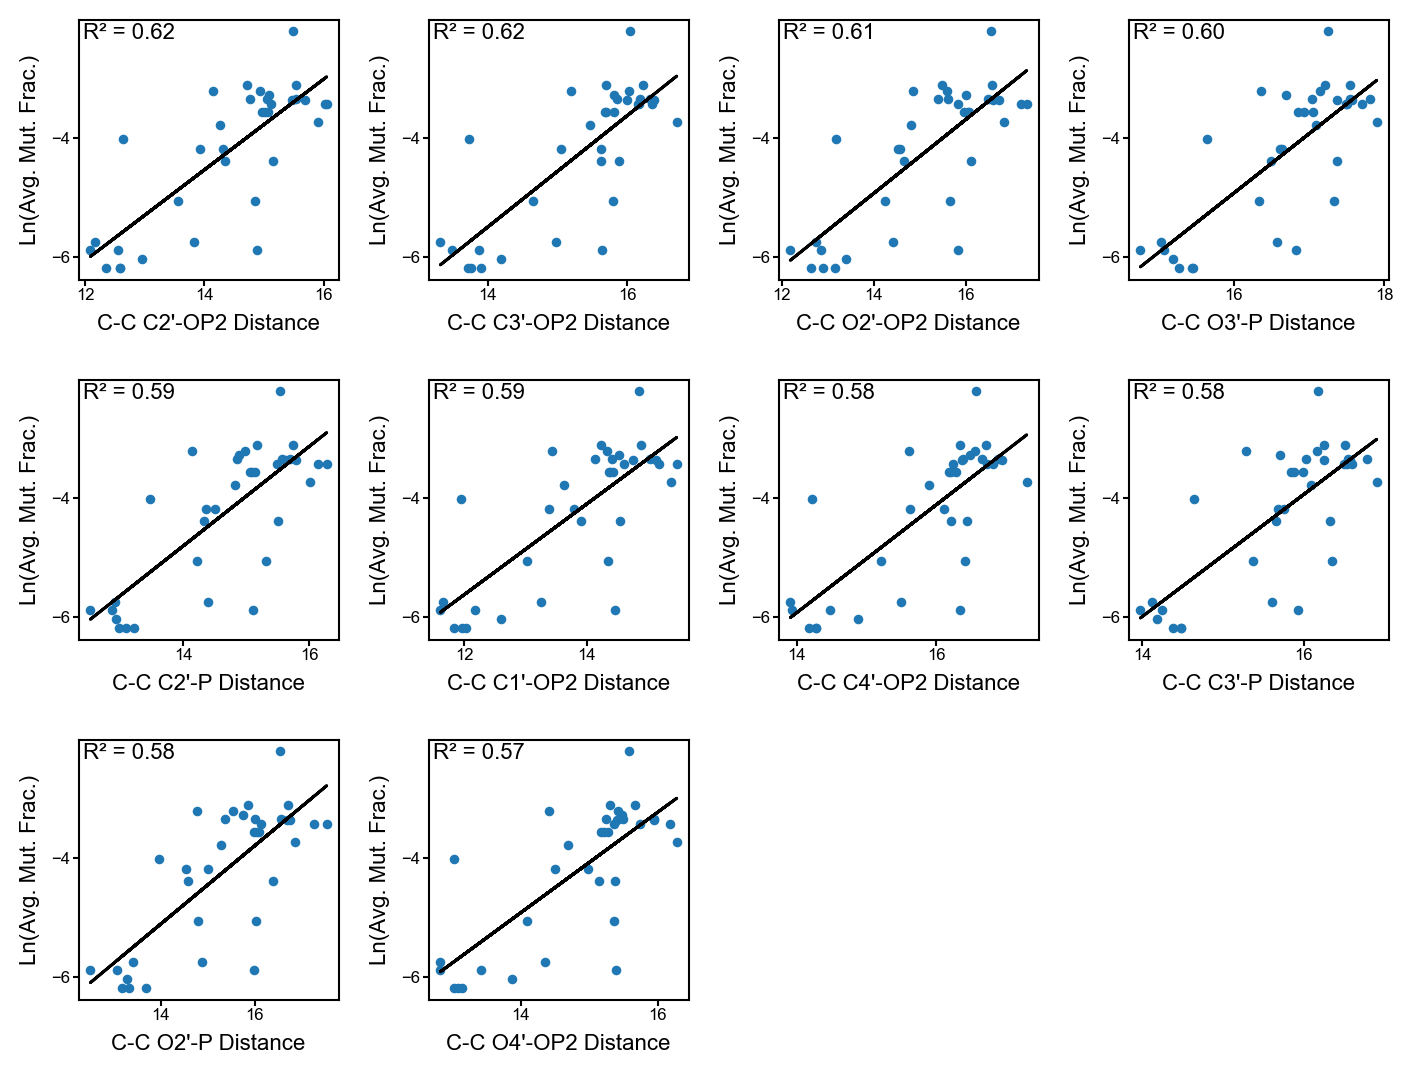

In [124]:
df_dist_cc = df_dist.query('pair == "C-C" and ln_r_data_mean != ""').copy()
df_unique = df_dist_cc.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"]).copy()
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

fig_size = (7, 4)
layout = (3, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
pos = 0
for i, row in df_top_10.iterrows():
    df_plot = df_dist.query(
        f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"'
    ).copy()
    ax = fig.add_axes(coords_list[pos])
    scatter_plot_w_regression(
        df_plot, ax, "distance", "ln_r_data_mean", r2_position=(0.37, 0.99)
    )
    ax.set_xlabel(f'C-C {row["atom1"]}-{row["atom2"]} Distance')
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
    publication_style_ax(ax)
    pos += 1
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s20.png",
    dpi=600,
    bbox_inches="tight",
)

## Supplemental Figure S21: Correlation plots for distance and reactivity for A-G pairs for the engineered 1x1 and 2x2 two-way junctions with low hydrogen bonds in the new dataset 

### extra functions

In [125]:
def get_r2(x, y):
    """
    Calculate the coefficient of determination (R^2) for two variables.

    Args:
    x (array-like): The first variable.
    y (array-like): The second variable.

    Returns:
    float: The R^2 value, which represents the proportion of the variance in the dependent variable
           that is predictable from the independent variable.
    """
    return pearsonr(x, y)[0] ** 2


def combine_old_and_new_data(df_old, df_new, data_type="reactivity"):
    """
    Combine old and new dataframes on the 'motif_name' column.

    Parameters:
    """
    df_old = df_old.copy()
    df_new = df_new.copy()
    if data_type == "reactivity":
        df_new.rename(columns={"ln_reactivity": "ln_r_data_mean"}, inplace=True)
        df = pd.concat([df_old, df_new])
        return df
    else:
        df_new.rename(columns={"reactivity_ratio": "ln_r_data_mean"}, inplace=True)


def get_best_fit_line(df, x_col, y_col):
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    return model


# Function to create scatter plot with linear regression for distance vs reactivity analysis
def create_scatter_plot_w_regression(df, ax, x_col, y_col, color_by_pdb_res=False):
    # Prepare the data
    X = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute R-squared
    r2 = r2_score(y, model.predict(X))

    if color_by_pdb_res:
        scatter = ax.scatter(X.flatten(), y, s=6, c=df["pdb_res"], cmap="viridis")
        plt.colorbar(scatter, ax=ax, label="PDB Residue")
    else:
        ax.scatter(X.flatten(), y, s=6)

    # Add regression line
    ax.plot(X, model.predict(X), color="black", linewidth=1)

    return r2

### load data

In [127]:
df_pdb = pd.read_json(f"{REVISION_PATH}/new_structures/pdb_info.json")

df_corr_data = pd.read_csv(f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv")
df_ratio_corr_data = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances_with_ratio.csv"
)
df_corr_new_data = pd.read_csv(f"{REVISION_PATH}/new_structures/non_wc_distances.csv")
df_corr_new_summary = pd.read_csv(
    f"{REVISION_PATH}/new_structures/non_wc_distances_reactivity_correlation.csv"
)

### subplots

A-G P-P original data r2 0.5068710179916277
A-G P-P number of original data points 122


KeyError: 'pdb_id'

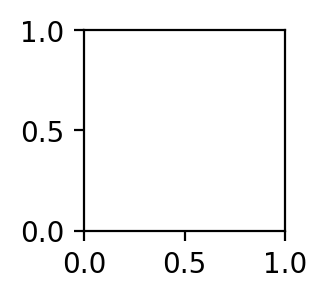

In [128]:
def plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax):
    """
    Plots A-G P-P distance vs ln(Avg. Mut. Frac.) for both original and new data on the given axis.

    Args:
        df_corr_data (pd.DataFrame): Original correlation data.
        df_corr_new_data (pd.DataFrame): New correlation data.
        df_pdb (pd.DataFrame): DataFrame with PDB info to merge on 'pdb_id'.
        ax (matplotlib.axes.Axes): Axis to plot on.

    Returns:
        None
    """
    # get original data
    df_corr_data_ag = df_corr_data.query(
        'pair == "A-G" and atom1 == "P" and atom2 == "P"'
    ).copy()
    df_corr_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    print(
        "A-G P-P original data r2",
        get_r2(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"]),
    )
    print(f"A-G P-P number of original data points", len(df_corr_data_ag))
    df_corr_data_ag = df_corr_data_ag.merge(df_pdb, on="pdb_id")
    # get new data
    df_corr_new_data_ag = df_corr_new_data.query(
        'pair == "A-G" and atom_1 == "P" and atom_2 == "P"'
    ).copy()
    df_corr_new_data_ag.sort_values(by="distance", ascending=False, inplace=True)
    df_corr_new_data_ag = add_motif_indentifier_columns(
        df_corr_new_data_ag, "motif_name"
    )
    df_corr_new_data_ag = df_corr_new_data_ag.merge(df_pdb, on="pdb_id")
    print(
        "A-G P-P new data r2",
        get_r2(df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"]),
    )
    print(f"A-G P-P number of new data points", len(df_corr_new_data_ag))
    # combine data
    df_combined_ag = combine_old_and_new_data(df_corr_data_ag, df_corr_new_data_ag)
    model = get_best_fit_line(df_combined_ag, "distance", "ln_r_data_mean")
    X = df_combined_ag["distance"].values.reshape(-1, 1)
    y = df_combined_ag["ln_r_data_mean"].values
    y_pred = model.predict(X)
    ax.scatter(df_corr_data_ag["distance"], df_corr_data_ag["ln_r_data_mean"], s=6)
    ax.scatter(
        df_corr_new_data_ag["distance"], df_corr_new_data_ag["ln_reactivity"], s=6
    )
    ax.plot(X, y_pred, color="black", linewidth=0.75)
    ax.set_xlabel("A-G P-P Distance (Å)", labelpad=2)
    ax.set_ylabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_xticks([12, 14, 16, 18, 20, 22])
    print(
        "A-G P-P combined data r2",
        get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"]),
    )
    # Add R2 annotation in the top right corner
    r2_value = get_r2(df_combined_ag["distance"], df_combined_ag["ln_r_data_mean"])
    ax.text(
        0.99,
        0.99,
        f"$R^2 = {r2_value:.2f}$",
        transform=ax.transAxes,
        fontsize=6,
        fontname="Arial",
        verticalalignment="top",
        horizontalalignment="right",
    )
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_ag_correlation(df_corr_data, df_corr_new_data, df_pdb, ax)

## Suppplemental Table 3: Residues under 2 A for SASA

In [ ]:
df_non_wc_pair = df_sasa_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''and m_token == '1x1'"
).copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Count |
|:-----------|------------------:|--------:|
| A in A-A   |             23.29 |  992.00 |
| A in A-C   |             62.43 |  668.00 |
| A in A-G   |             69.25 |  374.00 |
| C in C-A   |             51.66 |  664.00 |
| C in C-C   |             12.06 |  506.00 |
| C in C-U   |              0.00 |  521.00 |


## Supplemental Figure XXX: Reactive flanking base pairs for C

TypeError: plot_violins_w_percent() got an unexpected keyword argument 'text_offset'

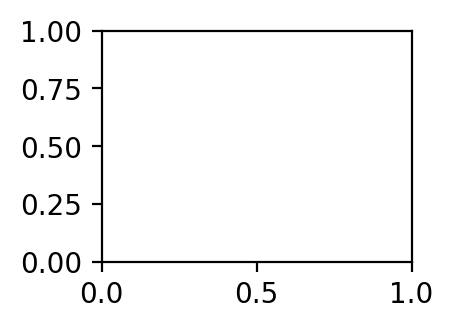

In [ ]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
df_pos["side_diff"] = [
    abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
]
df_pos["side_diff"] = df_pos["side_diff"].astype(str)
df_pos.sort_values("side_diff", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_pos, "ln_r_data", "side_diff", text_offset=0.75, color="tab:blue", ax=ax
)
ax.set_xlim(-12.5, -3)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
format_small_plot(ax)

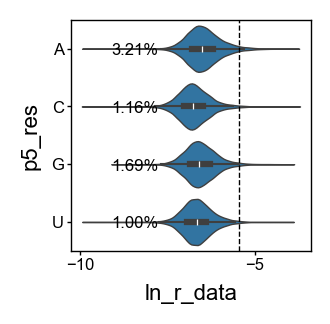

In [ ]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p5_res", color="tab:blue", ax=ax)
format_small_plot(ax)

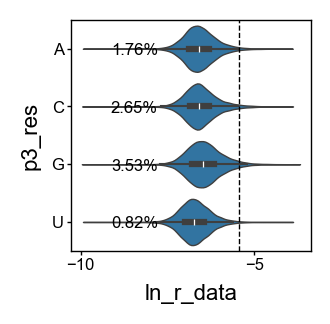

In [ ]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p3_res", color="tab:blue", ax=ax)
format_small_plot(ax)

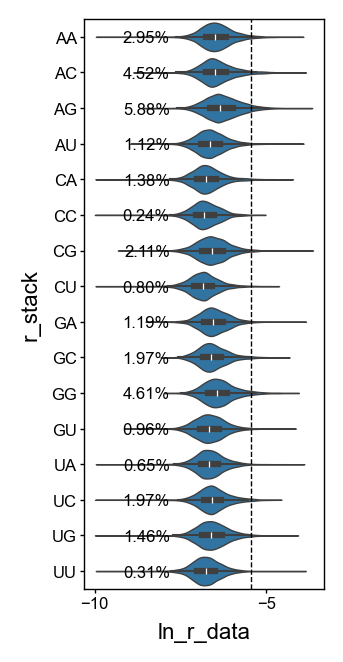

In [ ]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 3.7), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "r_stack", color="tab:blue", ax=ax)
format_small_plot(ax)

## Supplemental Figure XXX: Correlation between DMS reactivity and nomod

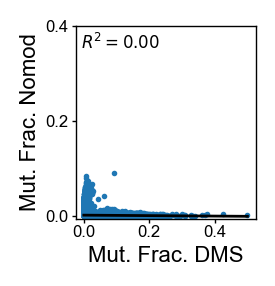

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)